In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sn
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn import datasets, linear_model
import sys

from pandas import DataFrame

from sklearn.metrics import confusion_matrix

# Binary Classification Using Lasso

In [2]:
df = pd.read_csv('./D2K_BCM_DATASET/4klog2Norm.tsv', sep='\t', index_col=0)
#df.set_index(df["Unnamed: 0"], inplace=True)

In [3]:
df = pd.read_csv('./D2K_BCM_DATASET/3690_all.tsv', sep='\t',index_col=0)
#df.set_index(df["Unnamed: 0"], inplace=True)

In [4]:
## separate control vs patient
control = df[df.MGS_LEVEL == 1]
stage2_patient = df[df.MGS_LEVEL == 2]
stage3_patient = df[df.MGS_LEVEL == 3]
stage4_patient = df[df.MGS_LEVEL == 4]

In [5]:
def compute_lasso(control, patient):
    ## 0 if stage is 1, 1 if stage is 1,2,3
    control["binary"] = 0
    patient["binary"] = 1
    
    ## merge two datasets vertically and remove mgs level
    new_df = control.append(patient, ignore_index=True)
    new_df = new_df.iloc[:,2:]
    
    ## split into X, Y variables
    X_train = new_df.iloc[:,:-1]
    y_train = new_df.iloc[:,-1]
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    sel_ = SelectFromModel(LogisticRegression(penalty='l1')) ##penalty is lasso regression
    sel_.fit(scaler.transform(X_train), y_train)
    
    lasso = linear_model.Lasso()
    cv_results = cross_validate(lasso, X_train, y_train)
    cv_results.keys()
    #cross_validate(sel2_, scaler.transform(X_train), y_train)
    
    ## Make a list of with the selected features.
    selected_feat = X_train.columns[(sel_.get_support())]
    
    ## Identifying the significant features
    sig_feats = X_train.columns[(sel_.estimator_.coef_ != 0).ravel().tolist()]

    
    ## Identifying the removed features
    removed_feats = X_train.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
    
    ## Removing the features from training
    ## 453 patients, select important features
    X_train_selected = sel_.transform(X_train)
    X_train_selected = np.transpose(X_train_selected)
    
    # get the dataframe for selected genes
    X_train_selected
    lasso_filtered = pd.DataFrame(data=X_train_selected, index=sig_feats)
    
    return lasso_filtered, sig_feats

In [6]:
s2_lasso_filtered, s2_sig_feats = compute_lasso(control, stage2_patient)
s3_lasso_filtered, s3_sig_feats = compute_lasso(control, stage3_patient)
s4_lasso_filtered, s4_sig_feats = compute_lasso(control, stage4_patient) 

/Users/minjunp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/minjunp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/minjunp/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' 

In [7]:
len(s2_sig_feats), len(s3_sig_feats), len(s4_sig_feats)

(162, 136, 86)

In [8]:
## stage 2 and 3 overlap
count = 0
for i in s2_sig_feats:
    if i in s3_sig_feats:
        count += 1
count

37

In [9]:
## stage 2 and 4 overlap
count = 0
for i in s2_sig_feats:
    if i in s4_sig_feats:
        count += 1
count

23

In [10]:
## stage 3 and 4 overlap
count = 0
for i in s3_sig_feats:
    if i in s4_sig_feats:
        count += 1
count

17

# plot filtered genes and correlation matrix

Text(0.5, 0.98, 'Genes selected in Stage 1 vs Stage 2')

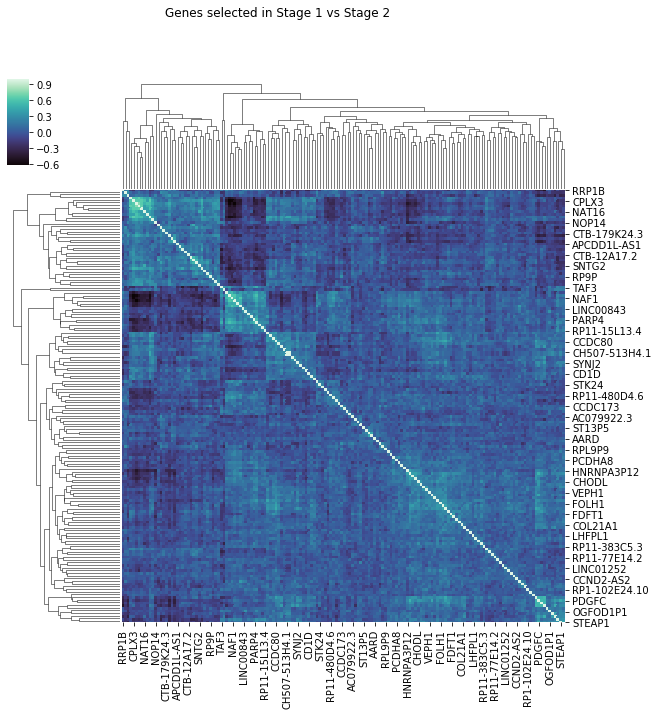

In [11]:
s2 = s2_lasso_filtered.T
corr = s2.corr()
g = sns.clustermap(corr,cmap="mako")
g.fig.suptitle('Genes selected in Stage 1 vs Stage 2')

Text(0.5, 0.98, 'Genes selected in Stage 1 vs Stage 3')

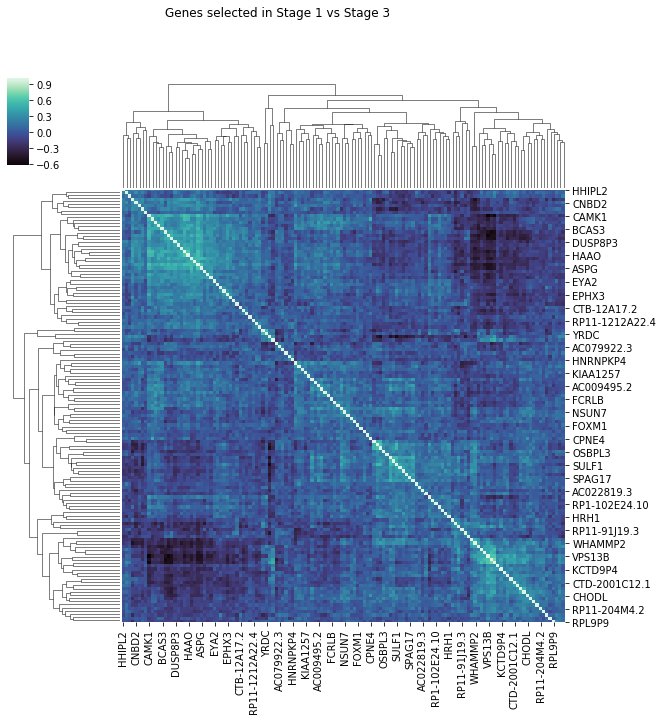

In [12]:
s3 = s3_lasso_filtered.T
corr = s3.corr()
g = sns.clustermap(corr,cmap="mako")
g.fig.suptitle('Genes selected in Stage 1 vs Stage 3')

Text(0.5, 0.98, 'Genes selected in Stage 1 vs Stage 4')

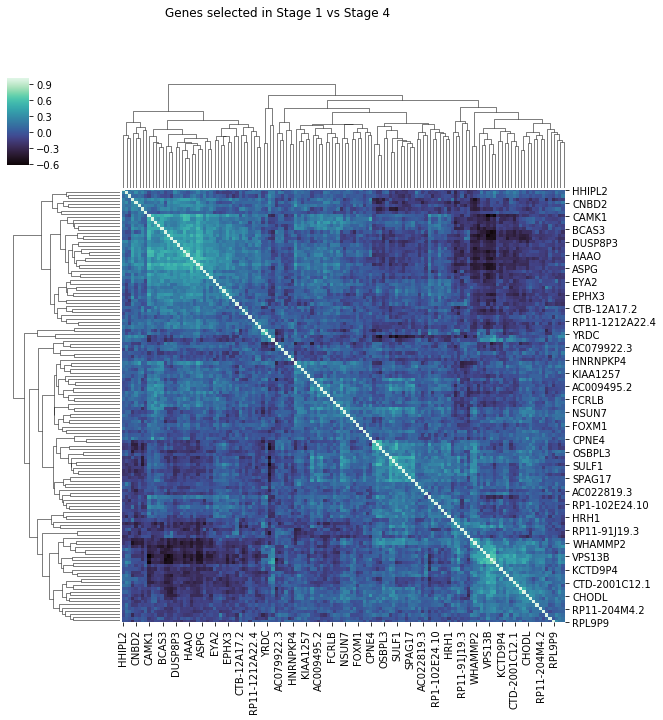

In [13]:
s4 = s4_lasso_filtered.T
corr = s3.corr()
g = sns.clustermap(corr,cmap="mako")
g.fig.suptitle('Genes selected in Stage 1 vs Stage 4')

# Find overlap in genes found to be important through Bootstrapping

In [14]:
s1df = pd.read_csv('./D2K_BCM_DATASET/ensl_bootstrap_stage1_genes.csv', sep='\t',delimiter=',', index_col=0)
s2df = pd.read_csv('./D2K_BCM_DATASET/ensl_bootstrap_stage2_genes.csv', sep='\t',delimiter=',', index_col=0)
s3df = pd.read_csv('./D2K_BCM_DATASET/ensl_bootstrap_stage3_genes.csv', sep='\t',delimiter=',', index_col=0)
s4df = pd.read_csv('./D2K_BCM_DATASET/ensl_bootstrap_stage4_genes.csv', sep='\t',delimiter=',', index_col=0)
#df.set_index(df["Unnamed: 0"], inplace=True)
s1df

,s1_var_names,Freq
1,ENSG00000003400,1
2,ENSG00000005243,1
3,ENSG00000006047,18
4,ENSG00000008226,1
5,ENSG00000009790,4
...,...,...
990,ENSG00000283578,13
991,ENSG00000283631,9
992,ENSG00000283654,4
993,ENSG00000283684,1


In [15]:
len(s1df[s1df["Freq"]>50])

21

In [16]:
len(s2df[s2df["Freq"]>58])

20

In [17]:
len(s3df[s3df["Freq"]>55])

20

In [18]:
len(s4df[s4df["Freq"]>30])

44

In [19]:
s1 = s1df[s1df["Freq"]>50]
s1_names = s1["s1_var_names"]

In [20]:
s2 = s2df[s2df["Freq"]>58]
s2_names = s2["s2_var_names"]

In [21]:
s3 = s3df[s3df["Freq"]>55]
s3_names = s3["s3_var_names"]

In [22]:
s4 = s4df[s4df["Freq"]>40]
s4_names = s4["s4_var_names"]

In [23]:
all_names = []
all_names.append(s1_names)
all_names.append(s2_names)
all_names
new = s1_names.append(s2_names)
new = new.append(s3_names)
new = new.append(s4_names)
new

88     ENSG00000117090
350    ENSG00000196796
367    ENSG00000201499
397    ENSG00000207002
427    ENSG00000215480
            ...       
542    ENSG00000261405
551    ENSG00000263574
553    ENSG00000263862
587    ENSG00000270269
618    ENSG00000273445
Length: 76, dtype: object

# Cluster heatmap and Correlation matrix of important genes selected for each stage

In [24]:
df = pd.read_csv('./D2K_BCM_DATASET/4kensembled.tsv', sep='\t', index_col=0)
#df.set_index(df["Unnamed: 0"], inplace=True)
df

,mgs_level,ENSG00000000003,ENSG00000001036,ENSG00000001084,ENSG00000001629,ENSG00000001631,ENSG00000002586,ENSG00000002933,ENSG00000003400,ENSG00000003509,...,ENSG00000283473,ENSG00000283486,ENSG00000283578,ENSG00000283611,ENSG00000283631,ENSG00000283635,ENSG00000283654,ENSG00000283674,ENSG00000283684,ENSG00000283692
0,2,9.698730,9.007920,11.074547,11.255878,10.578447,9.698730,9.853723,5.876924,9.770795,...,0.000000,9.213259,0.0,0.000000,0.0,2.014479,0.000000,6.376592,0.0,3.339286
1,1,9.181011,8.480250,10.224124,10.854084,10.851306,9.135288,9.296297,5.330312,9.875868,...,0.000000,8.289156,0.0,2.814728,0.0,2.006454,0.000000,6.358106,0.0,2.814728
2,3,8.998180,8.114741,10.315019,10.832309,10.474078,8.410391,9.031668,6.190813,9.971107,...,0.000000,9.550266,0.0,2.808214,0.0,0.000000,0.000000,6.285467,0.0,3.322830
3,4,8.623853,7.775116,10.114775,10.970147,10.669332,8.469199,8.489462,6.511398,10.078450,...,0.000000,9.065750,0.0,0.000000,0.0,2.587999,0.000000,7.421474,0.0,3.090678
4,1,9.265740,8.237808,10.334186,11.156822,10.967349,8.282984,9.324540,5.706331,10.097601,...,0.000000,9.771254,0.0,0.000000,0.0,2.887836,0.000000,6.282053,0.0,4.087801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,2,9.652843,8.638124,10.507940,11.335497,10.911493,8.570128,8.945976,6.026748,10.202071,...,2.020424,8.717590,0.0,2.020424,0.0,0.000000,0.000000,6.156067,0.0,3.346403
403,1,9.127804,8.374199,10.883195,11.187242,10.873519,8.996805,9.204022,6.145744,10.289314,...,0.000000,8.031268,0.0,0.000000,0.0,2.821679,2.821679,6.660388,0.0,2.821679
404,2,9.243243,8.064653,10.112397,10.585284,10.214353,9.163651,9.692132,6.114986,9.725775,...,0.000000,8.327665,0.0,0.000000,0.0,0.000000,2.088428,6.623301,0.0,0.000000
405,4,10.421857,9.482724,10.966361,11.653378,11.298931,8.820934,9.626921,6.645807,10.254308,...,0.000000,8.797960,0.0,0.000000,0.0,2.143544,0.000000,5.708102,0.0,3.492543


In [25]:
s1 = df[s1_names].T

In [26]:
s2 = df[s2_names].T

In [27]:
s3 = df[s3_names].T

In [28]:
s4 = df[s4_names].T

In [29]:
def plot_cluster(genes):
    #althought did not show very clear cluster, at some cluster, there are no of stage 4 patients
    g = sns.clustermap(genes)
    g.fig.suptitle('Cluster heatmap of important genes selected')

In [30]:
def plot_corr(genes):
    #correlation, might help for variable selection, since some genes might be have similiar effect, could help reduce dimension
    corr = genes.corr()
    g = sns.clustermap(corr,cmap="mako")

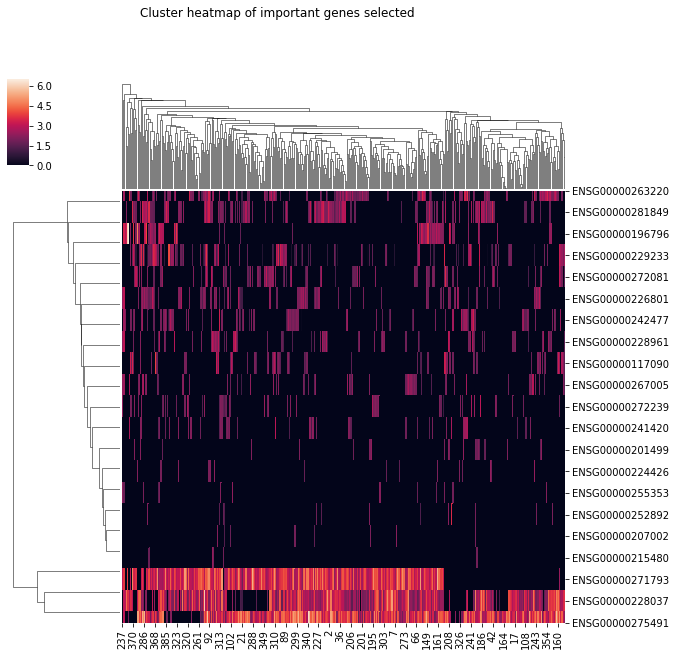

In [31]:
plot_cluster(s1)

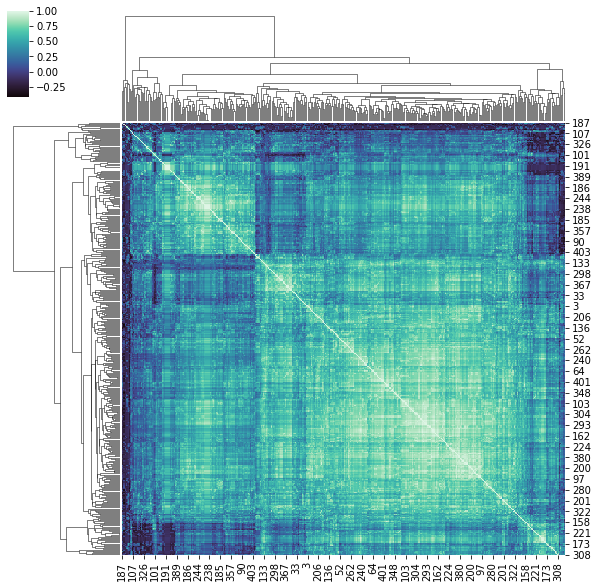

In [32]:
plot_corr(s1)

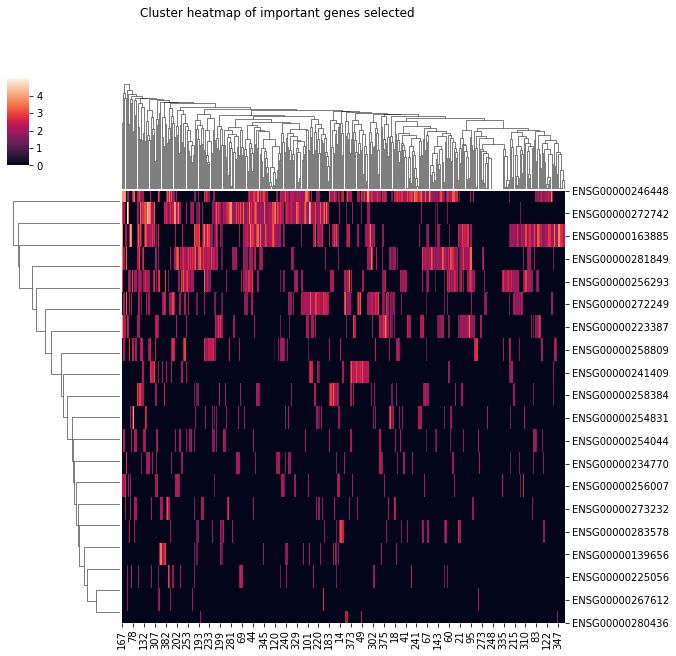

In [33]:
plot_cluster(s2)

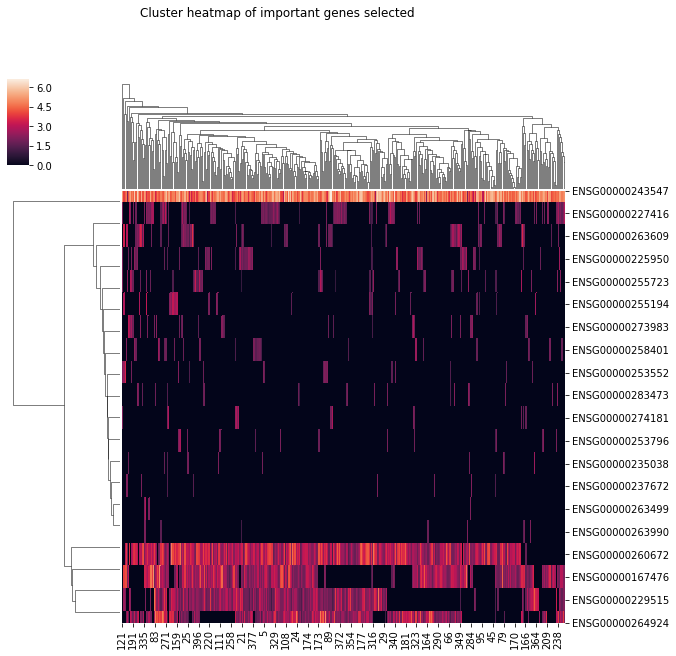

In [34]:
plot_cluster(s3)

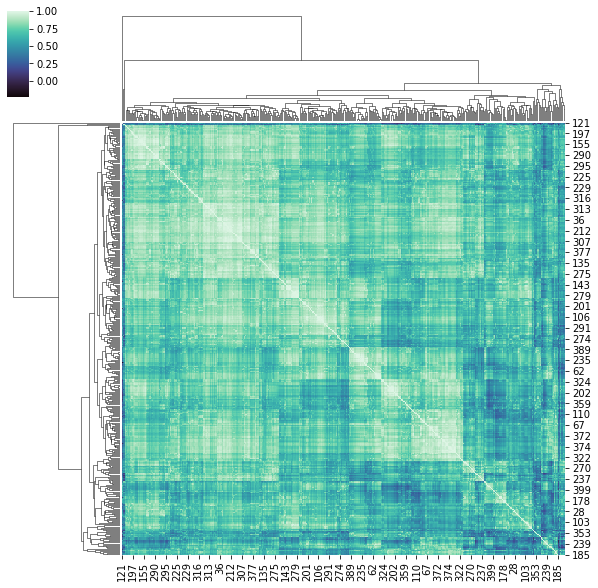

In [35]:
plot_corr(s3)

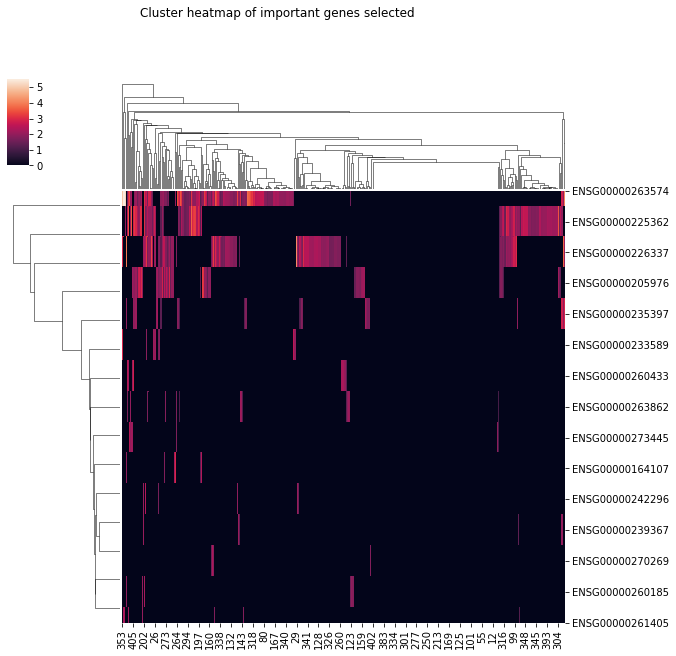

In [36]:
plot_cluster(s4)

# Confusion Matrix

Text(0.5, 1, 'Confusion matrix of Validation data')

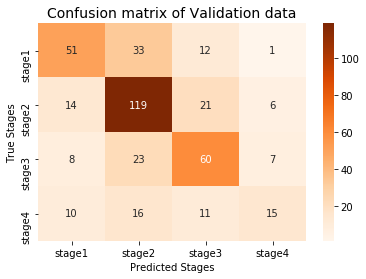

In [37]:
## 4 stages
y_test = np.array([3, 1, 2, 3, 2, 2, 2, 4, 2, 1, 4, 3, 2, 3, 3, 1, 2, 4, 2, 1, 3, 2, 2, 3, 1, 3, 3, 2, 3, 4, 1, 2, 2, 4, 1, 2, 4, 3, 3, 1, 2, 1, 3, 4, 1, 2, 4, 2, 1, 2, 1, 3, 4, 2, 2, 2, 1, 4, 2, 2, 1, 2, 2, 3, 3, 1, 1, 3, 1, 2, 1, 3, 3, 2, 1, 1, 4, 2, 1, 2, 4, 4, 1, 1, 2, 4, 2, 1, 2, 4, 2, 3, 3, 1, 3, 2, 2, 2, 2, 3, 4, 3, 2, 4, 3, 3, 3, 1, 2, 3, 2, 1, 2, 4, 2, 1, 1, 3, 4, 4, 3, 2, 1, 2, 2, 1, 1, 2, 1, 3, 1, 3, 3, 2, 3, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 3, 2, 3, 1, 2, 2, 2, 2, 3, 1, 1, 2, 3, 2, 1, 1, 1, 1, 1, 3, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 3, 4, 1, 2, 2, 2, 4, 2, 4, 2, 1, 3, 2, 2, 1, 4, 1, 3, 2, 4, 3, 2, 2, 1, 3, 2, 2, 1, 1, 3, 3, 1, 1, 1, 2, 3, 2, 2, 1, 2, 2, 2, 3, 1, 4, 4, 1, 3, 4, 2, 1, 1, 1, 4, 3, 2, 4, 1, 3, 3, 4, 3, 4, 2, 3, 3, 2, 2, 3, 2, 1, 4, 2, 2, 3, 2, 2, 2, 3, 2, 1, 4, 4, 1, 1, 4, 2, 3, 4, 2, 3, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 3, 2, 3, 3, 1, 2, 3, 2, 2, 2, 3, 4, 4, 3, 1, 2, 2, 2, 2, 2, 1, 1, 3, 2, 1, 1, 2, 2, 3, 4, 2, 3, 3, 4, 1, 3, 1, 4, 3, 2, 1, 4, 3, 4, 2, 2, 3, 2, 3, 3, 1, 2, 2, 2, 1, 2, 4, 3, 3, 3, 3, 2, 3, 3, 4, 2, 4, 3, 2, 2, 2, 2, 1, 3, 3, 2, 2, 2, 1, 2, 3, 4, 2, 3, 3, 1, 2, 2, 3, 1, 3, 2, 2, 2, 3, 2, 2, 4, 2, 3, 2, 2, 1, 3, 3, 3, 2, 4, 3, 3, 2, 1, 3, 4, 4, 2, 2])
predic = np.array([3, 2, 2, 3, 1, 3, 2, 4, 2, 1, 2, 3, 2, 3, 3, 2, 2, 1, 2, 1, 4, 2, 2, 3, 1, 2, 3, 2, 3, 4, 1, 2, 2, 3, 1, 4, 1, 2, 2, 1, 2, 3, 3, 2, 1, 2, 2, 4, 1, 2, 3, 3, 3, 2, 2, 2, 1, 4, 2, 2, 2, 2, 2, 3, 1, 1, 1, 3, 1, 2, 1, 3, 3, 2, 1, 1, 1, 2, 1, 2, 3, 4, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 3, 1, 2, 2, 2, 3, 1, 3, 3, 1, 3, 2, 1, 2, 2, 3, 3, 2, 2, 3, 2, 1, 2, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 4, 2, 2, 3, 2, 2, 1, 4, 2, 1, 3, 2, 2, 1, 2, 2, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 1, 1, 3, 2, 2, 4, 3, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 4, 3, 1, 1, 3, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 3, 2, 1, 2, 2, 2, 1, 2, 2, 3, 1, 3, 1, 2, 1, 1, 2, 3, 2, 2, 3, 3, 2, 2, 4, 3, 2, 3, 3, 3, 3, 2, 1, 2, 2, 3, 2, 1, 2, 2, 2, 2, 3, 2, 4, 4, 1, 2, 2, 2, 2, 1, 4, 3, 1, 1, 4, 1, 3, 3, 3, 3, 4, 2, 3, 3, 2, 3, 1, 2, 2, 4, 2, 3, 1, 2, 4, 2, 3, 2, 1, 3, 4, 2, 1, 4, 2, 2, 1, 2, 2, 1, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 2, 4, 3, 1, 2, 3, 2, 2, 1, 3, 2, 3, 3, 1, 1, 3, 2, 2, 2, 1, 1, 3, 2, 1, 3, 2, 3, 3, 4, 2, 2, 4, 4, 1, 3, 2, 1, 4, 2, 2, 3, 4, 3, 2, 2, 3, 2, 3, 2, 1, 2, 2, 2, 3, 1, 2, 3, 3, 2, 1, 2, 3, 3, 2, 2, 4, 1, 3, 2, 2, 3, 2, 3, 3, 2, 2, 3, 1, 2, 3, 2, 2, 2, 3, 1, 2, 2, 3, 2, 3, 1, 2, 3, 3, 1, 2, 4, 2, 2, 2, 2, 1, 2, 3, 3, 2, 3, 1, 3, 2, 1, 2, 2, 2, 2, 2])
columns = ['stage1', 'stage2', 'stage3', 'stage4']

confm = confusion_matrix(y_test, predic)
df_cm = DataFrame(confm, index=columns, columns=columns)

ax = sn.heatmap(df_cm, cmap='Oranges', annot=True,fmt="d")

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.xlabel('Predicted Stages', fontsize=10)
plt.ylabel('True Stages', fontsize=10)
plt.title('Confusion matrix of Validation data', fontsize=14)

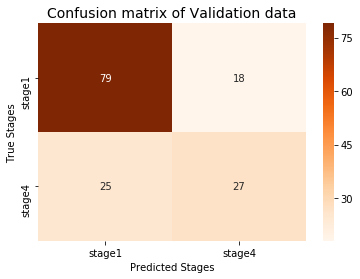

In [38]:
## 2 stages
y_test = np.array([1, 4, 4, 1, 1, 4, 1, 1, 4, 4, 1, 1, 1, 1, 1, 4, 1, 1, 4, 1, 4, 1, 4, 4, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 4, 1, 4, 1, 1, 1, 1, 1, 1, 4, 1, 1, 4, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 4, 1, 1, 1, 1, 4, 1, 4, 1, 1, 1, 1, 1, 4, 1, 1, 1, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 4, 4, 1, 4, 4, 4, 1, 1, 4, 4, 1, 4, 1, 1, 1, 1, 4, 1, 1, 4, 4, 1, 1, 4, 4, 4, 1, 1, 4, 4, 1, 1, 1, 1, 1, 4, 4, 4, 1, 4, 4, 4, 4, 4, 1, 4, 4, 1, 1, 1, 1, 4, 1])
predic = np.array([4, 4, 1, 1, 1, 4, 1, 1, 4, 4, 1, 1, 4, 1, 1, 4, 1, 1, 1, 1, 1, 4, 1, 4, 1, 1, 1, 4, 1, 1, 1, 1, 4, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 1, 4, 1, 1, 1, 4, 1, 1, 1, 4, 1, 4, 4, 4, 1, 4, 1, 1, 1, 1, 1, 1, 4, 1, 4, 4, 4, 1, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 4, 4, 4, 1, 1, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 4, 4, 1, 1, 1, 1, 4, 1, 1, 1, 1])
columns = ['stage1', 'stage4']

confm = confusion_matrix(y_test, predic)
df_cm = DataFrame(confm, index=columns, columns=columns)

ax = sn.heatmap(df_cm, cmap='Oranges', annot=True,fmt="d")

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.xlabel('Predicted Stages', fontsize=10)
plt.ylabel('True Stages', fontsize=10)
plt.title('Confusion matrix of Validation data', fontsize=14)
plt.show()

Text(0.5, 1, 'Confusion matrix of test data')

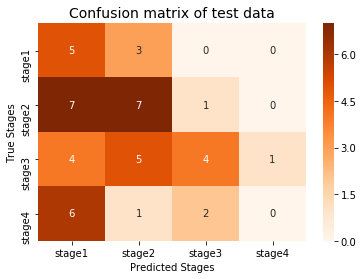

In [39]:
## 4 stages
y_test = np.array([2, 3, 4, 3, 1, 3, 2, 4, 3, 2, 1, 4, 4, 4, 4, 2, 4, 3, 3, 3, 3, 3, 2, 2, 3, 2, 1, 2, 2, 2, 2, 3, 4, 1, 1, 1, 3, 4, 3, 3, 2, 2, 1, 1, 2, 2])
predic = np.array([1, 1, 1, 3, 1, 2, 2, 1, 4, 1, 1, 2, 1, 1, 3, 1, 3, 2, 2, 2, 1, 3, 2, 2, 2, 3, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 3, 3, 1, 2, 1, 2, 1, 2])
columns = ['stage1', 'stage2', 'stage3', 'stage4']

confm = confusion_matrix(y_test, predic)
df_cm = DataFrame(confm, index=columns, columns=columns)

ax = sn.heatmap(df_cm, cmap='Oranges', annot=True,fmt="d")

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.xlabel('Predicted Stages', fontsize=10)
plt.ylabel('True Stages', fontsize=10)
plt.title('Confusion matrix of test data', fontsize=14)

Text(0.5, 1, 'Confusion matrix of test data')

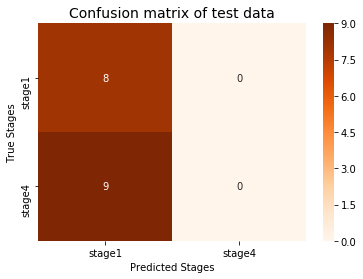

In [40]:
## 2 stages
y_test = np.array([4, 1, 4, 1, 4, 4, 4, 4, 4, 1, 4, 1, 1, 1, 4, 1, 1])
predic = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
columns = ['stage1', 'stage4']

#y_test = np.array([2, 3, 4, 3, 1, 3, 2, 4, 3, 2, 1, 4, 4, 4, 4, 2, 4, 3, 3, 3, 3, 3, 2, 2, 3, 2, 1, 2, 2, 2, 2, 3, 4, 1, 1, 1, 3, 4, 3, 3, 2, 2, 1, 1, 2, 2])
#predic = np.array([1, 1, 1, 3, 1, 2, 2, 1, 4, 1, 1, 2, 1, 1, 3, 1, 3, 2, 2, 2, 1, 3, 2, 2, 2, 3, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 3, 3, 1, 2, 1, 2, 1, 2])
#columns = ['stage1', 'stage2', 'stage3', 'stage4']

confm = confusion_matrix(y_test, predic)
df_cm = DataFrame(confm, index=columns, columns=columns)

ax = sn.heatmap(df_cm, cmap='Oranges', annot=True,fmt="d")

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.xlabel('Predicted Stages', fontsize=10)
plt.ylabel('True Stages', fontsize=10)
plt.title('Confusion matrix of test data', fontsize=14)